In [2]:
import tensorflow as tf
from keras import backend as K
from keras import layers, models
from keras.utils import to_categorical
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import cv2
import mediapipe as mp
from PIL import Image
import os
from random import shuffle
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
import seaborn as sns

In [16]:
# Carica il dataset
file = pd.read_csv('DataSet\A_Z Handwritten Data.csv')
# Separa le features (X) e le etichette (y)
X = file.iloc[:, 1:]
y = file.iloc[:, 0]

# Dividi i dati in set di addestramento e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Sovracampionamento delle classi minoritarie sul set di addestramento
#print("Sovracampionamento delle classi minoritarie")
#smote = SMOTE(random_state=42)
#X_train, y_train = smote.fit_resample(X_train, y_train)
# Normalizza i dati
standard_scaler = MinMaxScaler()
X_train = standard_scaler.fit_transform(X_train)
X_test = standard_scaler.transform(X_test)


# Reshape dei dati in modo da adattarli alla forma richiesta dai modelli CNN
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

# Codifica one-hot delle etichette
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


C:\Users\oligi\AppData\Local\Temp\ipykernel_344\3917900352.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=label_size, x=class_labels, palette=colors_from_values(label_size, "YlOrRd"))
C:\Users\oligi\AppData\Local\Temp\ipykernel_344\3917900352.py:24: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(y=label_size, x=class_labels, palette=colors_from_values(label_size, "YlOrRd"))
C:\Users\oligi\AppData\Local\Temp\ipykernel_344\3917900352.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=resampled_class_distribution.values, x=class_labels, palette=colors_from_values(label_size, "Y

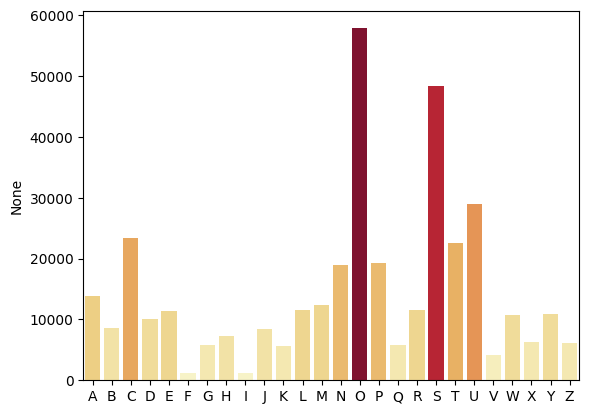

{0: 0.017281294445071777, 1: 0.02765046984987315, 2: 0.010238552379798389, 3: 0.02365051042615951, 4: 0.020950548309326966, 5: 0.2060827795861569, 6: 0.041595673838719274, 7: 0.03320508072301198, 8: 0.21399488630241115, 9: 0.028220213429730422, 10: 0.04277606151324299, 11: 0.020686541745097573, 12: 0.019428848302423838, 13: 0.012607799719026853, 14: 0.004144820971183753, 15: 0.012392031056238068, 16: 0.04123783080844812, 17: 0.02072231304329072, 18: 0.004950004598581145, 19: 0.010654557575403444, 20: 0.008262350822486917, 21: 0.05731092124789586, 22: 0.022224988191645076, 23: 0.038213372554001986, 24: 0.022071486569546044, 25: 0.03944606199122786}


In [17]:
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

alphabets_mapper = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'J',10:'K',11:'L',12:'M',13:'N',14:'O',15:'P',16:'Q',17:'R',18:'S',19:'T',20:'U',21:'V',22:'W',23:'X',24:'Y',25:'Z'} 
dataset_alphabets = file.copy()
dataset_alphabets.rename(columns={'0':'label'}, inplace=True)
dataset_alphabets['label'] = dataset_alphabets['label'].map(alphabets_mapper)
class_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
                'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
                'U', 'V', 'W', 'X', 'Y', 'Z']
dataset_alphabets = dataset_alphabets.groupby('label')
label_size=dataset_alphabets.size()
# Calcola la nuova distribuzione delle classi dopo il sovracampionamento
y_bo=np.argmax(y_train, axis=1)
resampled_class_distribution = pd.Series(y_bo).value_counts().sort_index()
#label_size=label_size.sort_index(ascending=False)
my_palette = sns.color_palette("coolwarm", len(label_size))
sns.barplot(y=label_size, x=class_labels, palette=colors_from_values(label_size, "YlOrRd"))
sns.barplot(y=resampled_class_distribution.values, x=class_labels, palette=colors_from_values(label_size, "YlOrRd"))
#label_size.plot.barh(figsize=(10,10), color=my_palette)
plt.show()
# Calcola il peso di ciascuna lettera
class_weights = {}
for letter, frequency in label_size.items():
    class_weights[ord(letter)-ord('A')] = 1 / frequency

# Normalizza i pesi
total_weight = sum(class_weights.values())
for letter, weight in class_weights.items():
  class_weights[letter] = weight / total_weight

# Stampa i pesi di classe
print(class_weights)



In [18]:
model = models.Sequential()

# Primo strato convoluzionale
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))

# Secondo strato convoluzionale
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flattening
model.add(layers.Flatten())

# Primo strato completamente connesso
model.add(layers.Dense(128, activation='relu'))

# Strato di output
model.add(layers.Dense(26, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 128)               2

In [19]:
#compilazione del modello
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'],)

In [20]:
from pathlib import Path
from time import strftime

def get_log(root="ASCII/Logs"):
    return Path(root) / strftime("run %Y-%m-%d %H-%M-%S")
run_log=get_log()
tensorboard=tf.keras.callbacks.TensorBoard(run_log,profile_batch=(100,200))

In [21]:
epoche=10
numero_batch=256
#training
# Training
# Addestramento del modello usando il generatore di immagini con data augmentation
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epoche, batch_size=numero_batch,callbacks=[tensorboard])

Epoch 1/10


1164/1164 [==============================] - 50s 41ms/step - loss: 0.2234 - accuracy: 0.9384 - val_loss: 0.0796 - val_accuracy: 0.9781
Epoch 2/10
1164/1164 [==============================] - 47s 40ms/step - loss: 0.0703 - accuracy: 0.9805 - val_loss: 0.0639 - val_accuracy: 0.9824
Epoch 3/10
1164/1164 [==============================] - 47s 40ms/step - loss: 0.0513 - accuracy: 0.9854 - val_loss: 0.0508 - val_accuracy: 0.9861
Epoch 4/10
1164/1164 [==============================] - 47s 40ms/step - loss: 0.0409 - accuracy: 0.9882 - val_loss: 0.0496 - val_accuracy: 0.9862
Epoch 5/10
1164/1164 [==============================] - 48s 41ms/step - loss: 0.0321 - accuracy: 0.9907 - val_loss: 0.0418 - val_accuracy: 0.9888
Epoch 6/10
1164/1164 [==============================] - 47s 41ms/step - loss: 0.0258 - accuracy: 0.9925 - val_loss: 0.0358 - val_accuracy: 0.9905
Epoch 7/10
1164/1164 [==============================] - 47s 40ms/step - loss: 0.0203 - accuracy: 0.9938 - val_loss: 0.0351

In [22]:
%load_ext tensorboard
print(run_log)
%tensorboard --logdir=./ASCII/Logs

ASCII\Logs\run 2024-03-20 19-24-40


Launching TensorBoard...

2328/2328 [==============================] - 19s 8ms/step - loss: 0.0315 - accuracy: 0.9929
Test accuracy: 0.992925226688385
Test loss: 0.0315064899623394


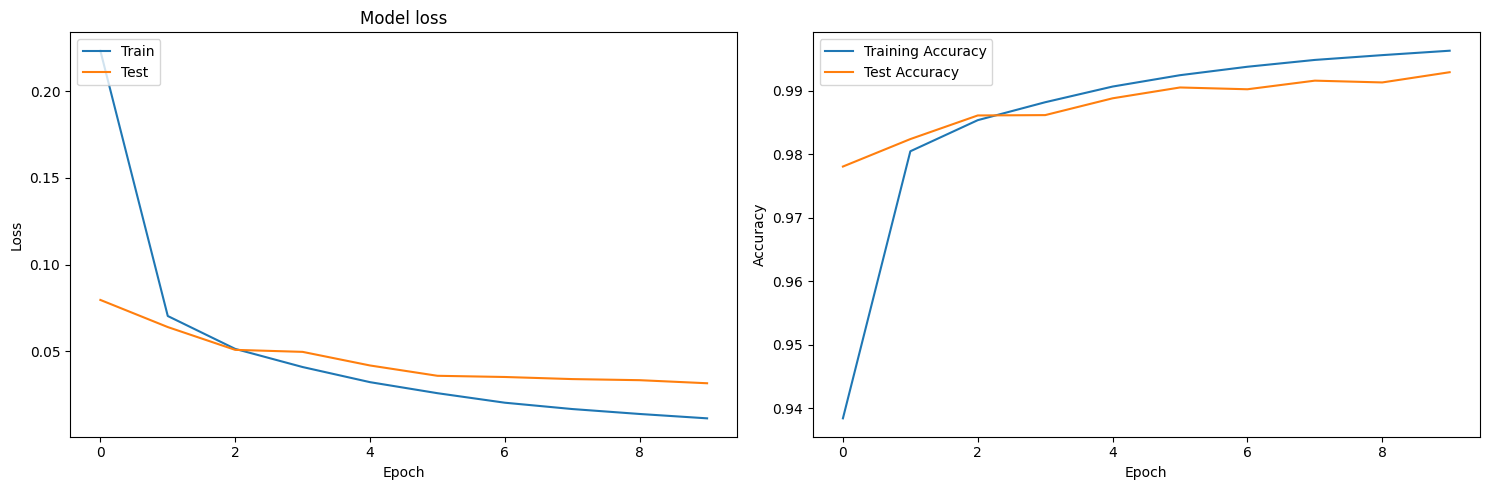

C:\Users\oligi\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

# Plot della Loss e dell'Accuracy
plt.figure(figsize=(15, 5))

# Plot della Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot dell'Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
#plt.plot(range(epoche), [test_acc] * epoche, label='Test Accuracy', linestyle='--', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Salva il modello
model.save('ASCII_model.h5')


2328/2328 [==============================] - 18s 8ms/step


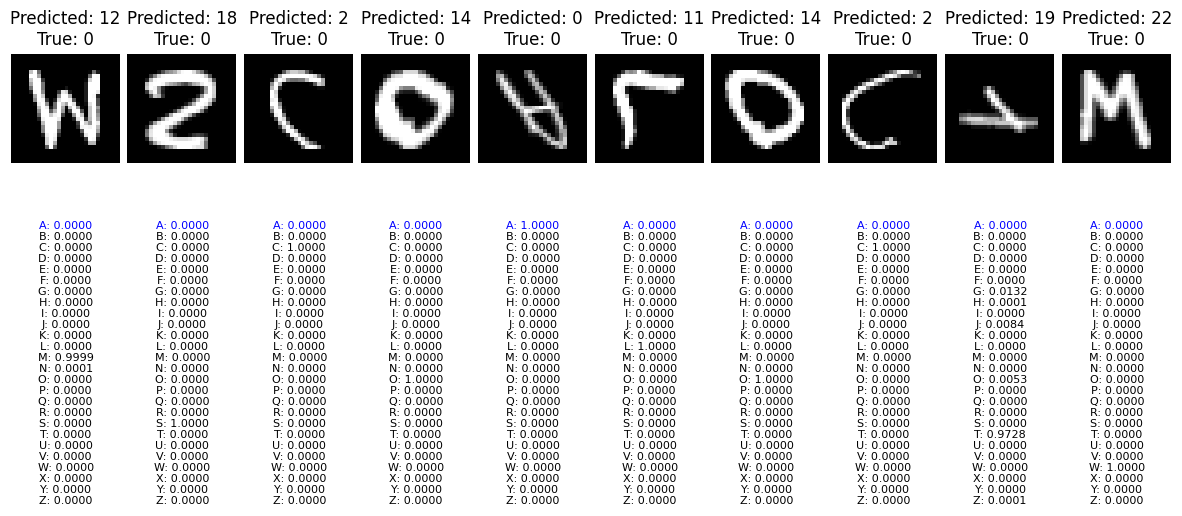

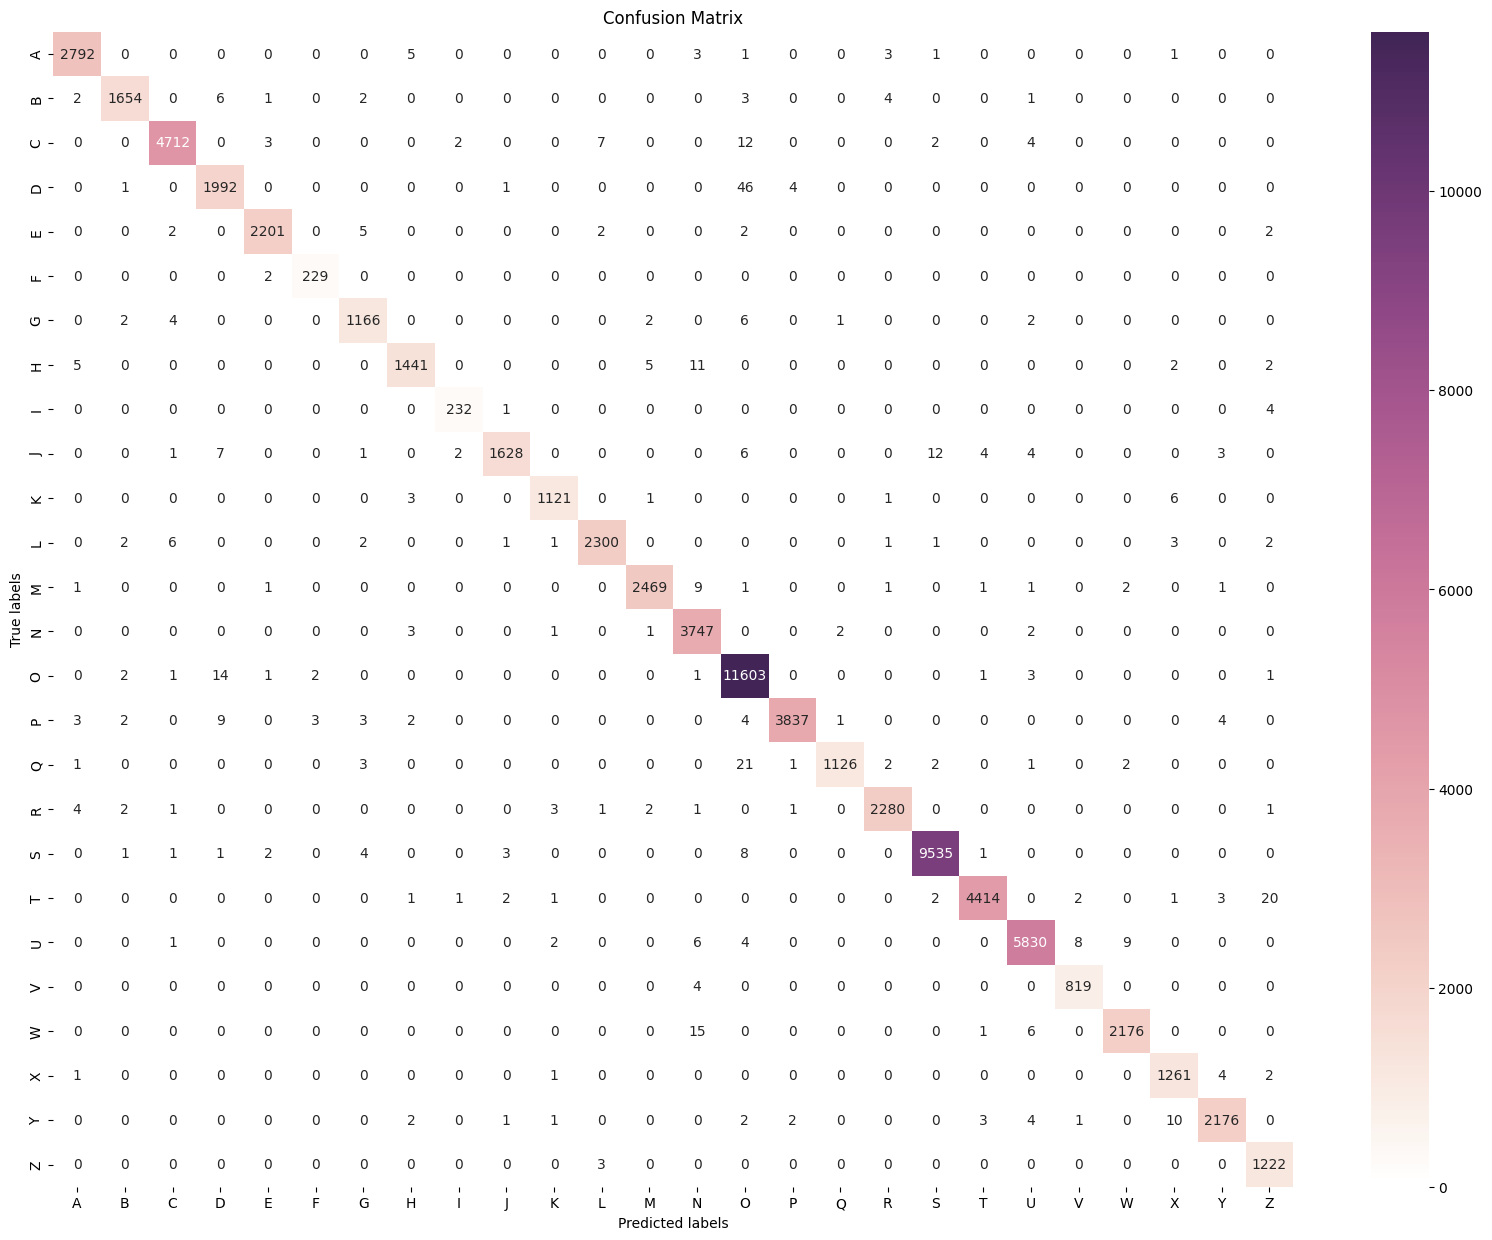

In [24]:
def plot_predictions_with_probabilities(model, X_test_reshaped, y_test_categorical):
    # Generate predictions
    predictions = model.predict(X_test_reshaped)
    predicted_labels = np.argmax(predictions, axis=1)
    y_test_categorical = np.argmax(y_test, axis=1)
    # Set image dimensions
    img_height, img_width = 28, 28
    figsize_height, figsize_width = 3, 15
    tot = 10

    # Create a figure
    fig, axes = plt.subplots(nrows=2, ncols=tot, figsize=(figsize_width, figsize_height))
    fig.subplots_adjust(wspace=0.05, hspace=0.1)

    # Iterate over predictions
    for i in range(tot):
        # Display the image and set dimensions
        axes[0, i].imshow(np.squeeze(X_test_reshaped[i]), cmap='gray')
        axes[0, i].set_title(f'Predicted: {np.argmax(predictions[i])}\nTrue: {np.argmax(y_test_categorical[i])}')
        axes[0, i].axis('off')

        # Print probabilities for each class
        probabilities = predictions[i]
        for j in range(len(probabilities)):
            axes[1, i].text(0.5, 0.5 - j * 0.1, f"{chr(65 + j)}: {probabilities[j]:.4f}",
                            transform=axes[1, i].transData,
                            color='blue' if j == np.argmax(y_test_categorical[i]) else 'black',
                            fontsize=8, ha='center', bbox={'facecolor': 'white', 'edgecolor': 'white', 'pad': 0})

        # Set cell dimensions
        axes[0, i].set_aspect('equal', adjustable='box')
        axes[0, i].set_xlim([0, img_width])
        axes[0, i].set_ylim([0, img_height])

        # Remove axes for the probability cell
        axes[1, i].axis('off')

    # Remove axes for all cells
    for ax in axes.flat:
        ax.axis('off')
        
    class_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
                'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
                'U', 'V', 'W', 'X', 'Y', 'Z']
    # Show the figure
    plt.show()
    cm = confusion_matrix(y_test_categorical, predicted_labels)
    m=2.5
    cmap=sns.cubehelix_palette(light=1, as_cmap=True,hue=1, dark=0.2)
    plt.figure(figsize=(8*m, 6*m))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Execute the code
plot_predictions_with_probabilities(model, X_test, y_test)


In [4]:
if not ('model' in locals() or 'model' in globals()):
    print("Caricamento del modello")
    model=tf.keras.models.load_model('ASCII_model.h5')
def leggi_numeroimmagine():
    try:
        df = pd.read_json("config.json", orient="records", lines=True)
        numeroimmagine = df["numeroimmagine"].iloc[0]
    except (FileNotFoundError, pd.errors.EmptyDataError, IndexError):
        numeroimmagine = 0

    return numeroimmagine
def estrai_parte_disegnata(imagecanvas):
    gray = cv2.cvtColor(imagecanvas, cv2.COLOR_BGR2GRAY)
    _, threshold = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(threshold, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Trova i limiti dell'area disegnata
        x, y, w, h = cv2.boundingRect(np.vstack(contours))

        # Ritaglia l'immagine originale solo all'area disegnata
        bordo = 20
        if h > w:
            offset = (h - w) // 2
            drawn_part = imagecanvas[y-bordo:y+h+bordo, x-bordo-offset:x+w+bordo+offset]
        else:
            offset = (w - h) // 2
            drawn_part = imagecanvas[y-bordo-offset:y+h+bordo+offset, x-bordo:x+w+bordo]
    else:
        # Se non ci sono contorni, restituisci un'immagine vuota
        drawn_part = np.zeros_like(imagecanvas)

    return drawn_part


def cam():
    imagecanvas = np.zeros((480, 640, 3), dtype="uint8")
    numeroimmagine = leggi_numeroimmagine()
    x1, y1 = 0, 0
    punte = [4, 8, 12, 16, 20]
    iniziodita = [1, 5, 9, 13, 17]
    detector = mp.solutions.hands
    hands = detector.Hands()
    mpDraw = mp.solutions.drawing_utils
    cap = cv2.VideoCapture(0)

    while cap.isOpened():
        success, img = cap.read()
        img = cv2.flip(img, 1)
        results = hands.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        combined_image = cv2.addWeighted(img, 0.7, imagecanvas, 0.3, 0)
        if results.multi_hand_landmarks:
            for handLms in results.multi_hand_landmarks:
                mpDraw.draw_landmarks(img, handLms, detector.HAND_CONNECTIONS)
                landmarks = handLms.landmark
                posizione = dita_alzate(punte, iniziodita, landmarks)

                if posizione == [1, 1, 0, 0, 0]:
                    #print("draw mode")
                    cv2.putText(combined_image, "draw mode", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                    x, y = int(landmarks[8].x * imagecanvas.shape[1]), int(landmarks[8].y * imagecanvas.shape[0])

                    if x1 == 0 and y1 == 0:
                        x1, y1 = x, y

                    cv2.line(img, (x, y), (x1, y1), (255, 255, 255), 10)
                    cv2.line(imagecanvas, (x, y), (x1, y1), (255, 255, 255), 10)
                    x1, y1 = x, y
                else:
                    x1, y1 = 0, 0
                
                # Converte l'immagine in un array NumPy e normalizzala
                immage=estrai_parte_disegnata(imagecanvas)
                immage=Image.fromarray(immage)
                immage=immage.convert('L')
                immage=immage.resize((28,28))
                dati_immagine = np.array(immage) / 255.0

                # Aggiungi una dimensione per simulare il batch (1, 28, 28, 1)
                dati_immagine_normalizzati = np.expand_dims(dati_immagine, axis=(0, 3))
                # Effettua le predizioni
                predizioni = model.predict(dati_immagine_normalizzati)

                for classe in predizioni:
                    probabilita_classi = list(enumerate(classe))
                    probabilita_classi.sort(key=lambda x: x[1], reverse=True)
                    
                    print("Probabilità per ogni classe (in ordine decrescente):")
                    for i, (indice_classe, probabilita) in enumerate(probabilita_classi):
                        print(f"Classe {chr(65 + indice_classe)}: {probabilita}")

                # Le predizioni sono nella forma di probabilità per ogni classe, puoi ottenere la classe predetta usando argmax
                classe_predetta = chr(65 + np.argmax(predizioni))
                print(f"Classe predetta: {classe_predetta}")

                cv2.putText(combined_image, f"Classe predetta: {classe_predetta}", (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                
                if posizione == [1, 1, 1, 1, 1]:
                    drawn_part = estrai_parte_disegnata(imagecanvas)
                    if np.count_nonzero(drawn_part) != 0:
                        cv2.imwrite(f"Immagini/parte_disegnata{numeroimmagine}.png", drawn_part)
                        numeroimmagine += 1
                        # Resettare il canvas dopo aver salvato la parte disegnata
                        imagecanvas = np.zeros((480, 640, 3), dtype="uint8")

                for id, lm in enumerate(handLms.landmark):
                    h, w, c = img.shape
                    cx, cy = int(lm.x * w), int(lm.y * h)

                    if id == 0:
                        cv2.circle(img, (cx, cy), 15, (255, 0, 255), cv2.FILLED)

        cv2.imshow("Combined", combined_image)
        infoaggiuntive=False
        if infoaggiuntive:
            cv2.imshow("Image", img)
            cv2.imshow("Canvas", imagecanvas)
        key = cv2.waitKey(1)

        if key == ord('q') or key == 27:
            break

    cap.release()
    cv2.destroyAllWindows()
    df = pd.DataFrame({"numeroimmagine": [numeroimmagine]})
    df.to_json("config.json", orient="records", lines=True)
def dita_alzate(punte, iniziodita, landmarks):
    dita = []
    for i in range(5):
        if landmarks[0]:
            if i != 0:
                punto0 , punto1 = float(landmarks[0].y), float(landmarks[iniziodita[i]].y)
                if not min(punto0, punto1)<landmarks[punte[i]].y < max(punto0, punto1):
                    dita.append(1)
                else:
                    dita.append(0)
            else:
                punto0 , punto1 = float(landmarks[3].x), float(landmarks[iniziodita[i]].x)
                if not min(punto0, punto1)<landmarks[punte[i]].x < max(punto0, punto1):
                    dita.append(1)
                else:
                    dita.append(0)
    return dita
cam()


Caricamento del modello


1/1 [==============================] - 0s 359ms/step
Probabilità per ogni classe (in ordine decrescente):
Classe T: 0.07586884498596191
Classe J: 0.07264026999473572
Classe C: 0.07177259027957916
Classe Y: 0.0675223171710968
Classe L: 0.06424760073423386
Classe U: 0.04808337613940239
Classe I: 0.04297821223735809
Classe S: 0.042494114488363266
Classe P: 0.04097452387213707
Classe Z: 0.038274116814136505
Classe O: 0.035450901836156845
Classe H: 0.0341353714466095
Classe N: 0.03349820524454117
Classe E: 0.032593317329883575
Classe V: 0.03228214755654335
Classe G: 0.03155037388205528
Classe K: 0.03122282214462757
Classe X: 0.029542678967118263
Classe W: 0.029512833803892136
Classe M: 0.026093438267707825
Classe D: 0.02416454441845417
Classe A: 0.023660702630877495
Classe F: 0.02246849238872528
Classe Q: 0.018202705308794975
Classe R: 0.016423167660832405
Classe B: 0.014342346228659153
Classe predetta: T
1/1 [==============================] - 0s 54ms/step
Probabil

In [3]:
print("Inserisci il numero dell'immagine da predire: ")
numeroimmagine = leggi_numeroimmagine()-1
print(f"Numero immagine: {numeroimmagine}")
# Inserisci il percorso dell'immagine
percorso_immagine = f"Immagini/parte_disegnata{numeroimmagine}.png"
# Carica l'immagine utilizzando la libreria PIL
immagine = Image.open(percorso_immagine).convert('L')  # 'L' indica la modalità scala di grigi
print("ciao")
# Ridimensiona l'immagine alle dimensioni attese dal modello (28x28)
immagine = immagine.resize((28, 28))
# Visualizza l'immagine utilizzando matplotlib
plt.imshow(immagine, cmap='gray')
plt.title("Immagine")
plt.axis("off")  # Nasconde gli assi
plt.show()

# Converte l'immagine in un array NumPy e normalizzala
dati_immagine = np.array(immagine) / 255.0

# Aggiungi una dimensione per simulare il batch (1, 28, 28, 1)
dati_immagine_normalizzati = np.expand_dims(dati_immagine, axis=(0, 3))
if not 'model' in locals() or 'model' in globals():
    print("Caricamento del modello")
    model=tf.keras.models.load_model('ASCII_model.h5')
# Effettua le predizioni
predizioni = model.predict(dati_immagine_normalizzati)

for classe in predizioni:
    probabilita_classi = list(enumerate(classe))
    probabilita_classi.sort(key=lambda x: x[1], reverse=True)
    
    print("Probabilità per ogni classe (in ordine decrescente):")
    for i, (indice_classe, probabilita) in enumerate(probabilita_classi):
        print(f"Classe {chr(65 + indice_classe)}: {probabilita}")


# Le predizioni sono nella forma di probabilità per ogni classe, puoi ottenere la classe predetta usando argmax
classe_predetta = chr(65 + np.argmax(predizioni))
print(f"Classe predetta: {classe_predetta}")

# Salva l'immagine predetta nella directory corrispondente
path = f"Immagini_postWork/{classe_predetta}"
elementi = os.listdir(path)
immagine.save(f"{path}/immagine{len(elementi)}.png")


Inserisci il numero dell'immagine da predire: 


NameError: name 'leggi_numeroimmagine' is not defined